# DA5401 Assignment 5
# Visualizing Data Veracity Challenges in Multi-Label Classification
## Name : R M Badri Narayanan
## Roll No. : ME22B225


# Part A : Preprocessing and Initial Setup

### Importing necessary libraries

In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from collections import Counter

## 1. Data Loading

In [23]:
data,meta = arff.loadarff("yeast.arff")

In [24]:
df = pd.DataFrame(data)

In [25]:
df.to_csv('MULAN.csv')

astype is used to set the datatype. X contains floating type values hence using float, Y on the other hand contains class labels which takes up integer values hence using int

In [26]:
X = df.iloc[:, :-14].values.astype(float)
Y = df.iloc[:, -14:].astype(int)

## 2. Dimensionality Check

In [27]:
print("Feature matrix shape:", X.shape)
print("Target matrix shape:", Y.shape)

Feature matrix shape: (2417, 103)
Target matrix shape: (2417, 14)


## 3. Label selection for visualisation

### Creating a new target variable 'two most frequent single-label classes' 

#### First I found out all the single label entries. The row sum will be 1 for those entries (Only one will be 1, others will be 0)

In [28]:
single_label_mask = (Y.sum(axis=1) == 1)
single_labels = Y[single_label_mask]

#### Now single_labels will be a dataframe, with only those records having only one label (Only one column will be 1 here, see below)

In [29]:
single_labels.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
171,1,0,0,0,0,0,0,0,0,0,0,0,0,0
524,1,0,0,0,0,0,0,0,0,0,0,0,0,0
552,1,0,0,0,0,0,0,0,0,0,0,0,0,0
674,1,0,0,0,0,0,0,0,0,0,0,0,0,0
692,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Now i only pick out the classes from these entries, and make a list of them

In [30]:
single_label_list = []
for i, row in single_labels.iterrows():
    label = row[row == 1].index[0]
    single_label_list.append(label)

#### Now this single_label_list will be a list of all occurences of all these single label classes. 

#### Next, i'm picking out only top 2 most frequent single label classes

In [31]:
single_counts = Counter(single_label_list)
top2_singles = [label for label, _ in single_counts.most_common(2)]

In [32]:
print(top2_singles)

['Class1']


#### An interesting observation is, Only class1 is a single_label class i.e All other labels occur only as a combination other than Class1 !

### Creating a new target variable 'most frequent multi-label combination' 

#### Identifying the multi label entries (Multi label entries will have more than one 1, hence sum would be > 1)

In [33]:
multi_label_rows = Y[Y.sum(axis=1) > 1]
multi_label_list = [tuple(row[row==1].index) for _, row in multi_label_rows.iterrows()] # This creates a list of tuples
# Each tuple will have the list of classes that each particular row is labelled as.

#### Now picking out the most common multi label combination 

In [34]:
multi_counts = Counter(multi_label_list)
most_common_multi = multi_counts.most_common(1)[0][0]
print(most_common_multi)

('Class3', 'Class4', 'Class12', 'Class13')


#### So, The most common multi label combination is ('Class3', 'Class4', 'Class12', 'Class13')

### Creating the Final target variable list for plotting

In [35]:
labels_for_vis = []
for _, row in Y.iterrows():
    active_labels = set(row[row==1].index)
    if active_labels == set(most_common_multi):
        labels_for_vis.append("Multi-Common")
    elif len(active_labels) == 1 and list(active_labels)[0] in top2_singles:
        labels_for_vis.append("Top-2-Single")
    else:
        labels_for_vis.append("Other")

labels_for_vis = pd.Series(labels_for_vis, name="VisLabel")
print(labels_for_vis.value_counts())


VisLabel
Other           2148
Multi-Common     237
Top-2-Single      32
Name: count, dtype: int64


## 4. Scaling

If the features in the dataset have different scales (e.g., one feature ranges from 0 to 100,000, and another from 0 to 1), the feature with the larger range will dominate the distance calculation, effectively overshadowing the contribution of features with smaller ranges. Features with larger values will have a disproportionately large effect on the calculated distance between any two points. This leads to a dimensionality reduction solution that is biased toward the high-magnitude features, potentially failing to capture the true underlying structure. Scaling ensures that all features contribute approximately equally to the distance computation.

# Part B : t-SNE and Veracity Inspection

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Visualising t-SNE results with different perplexities

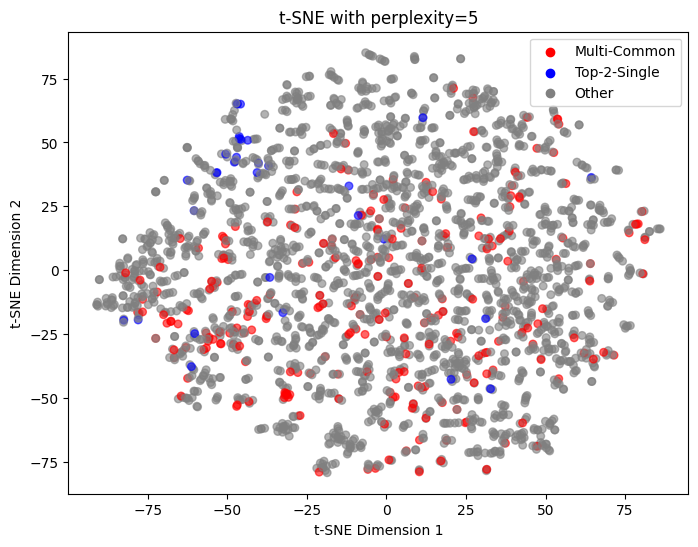

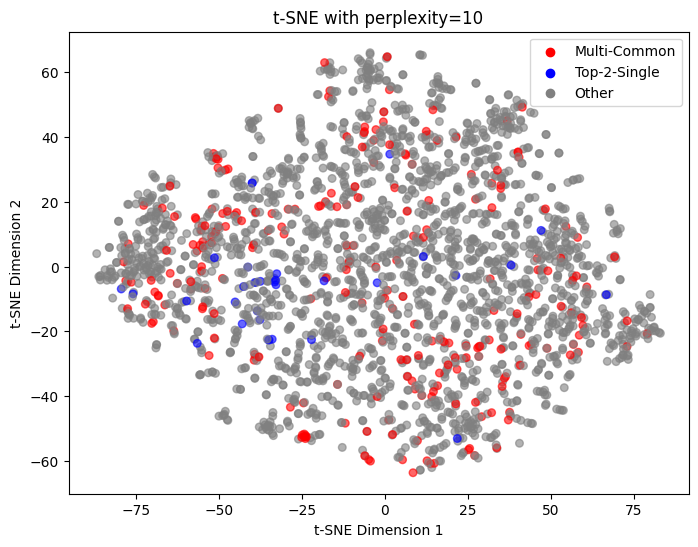

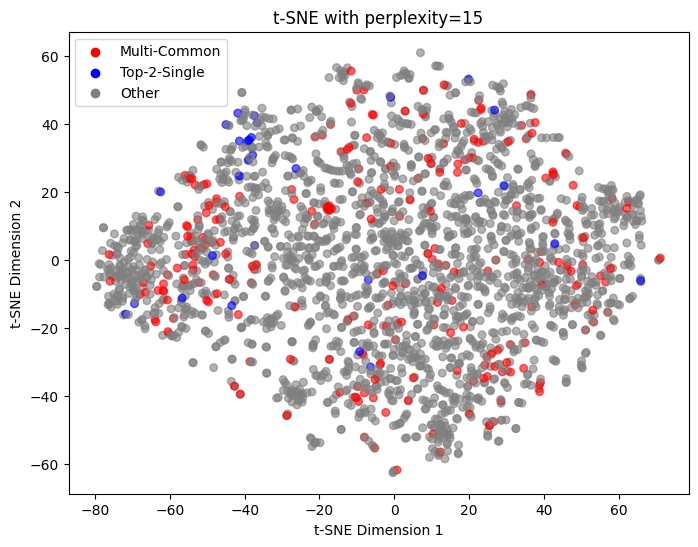

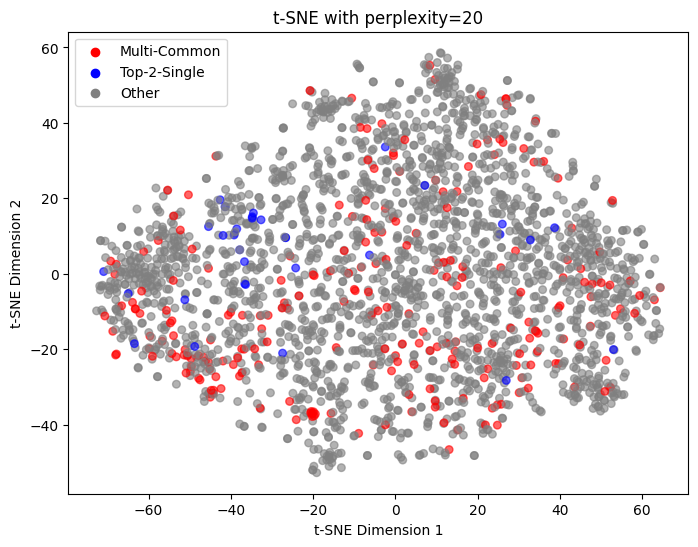

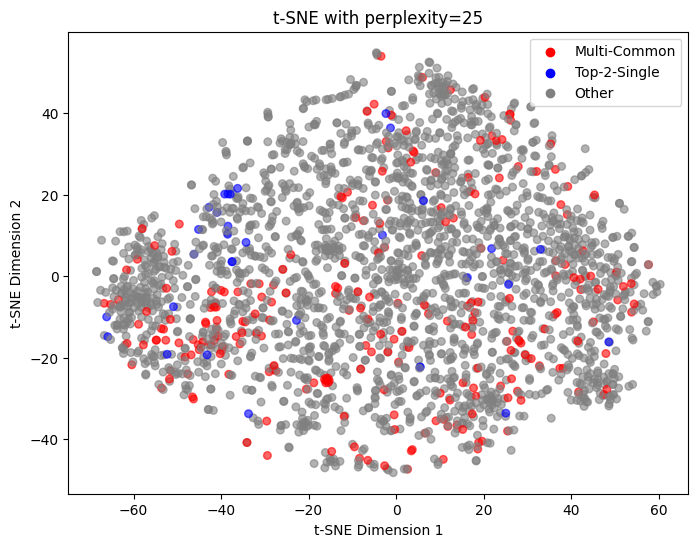

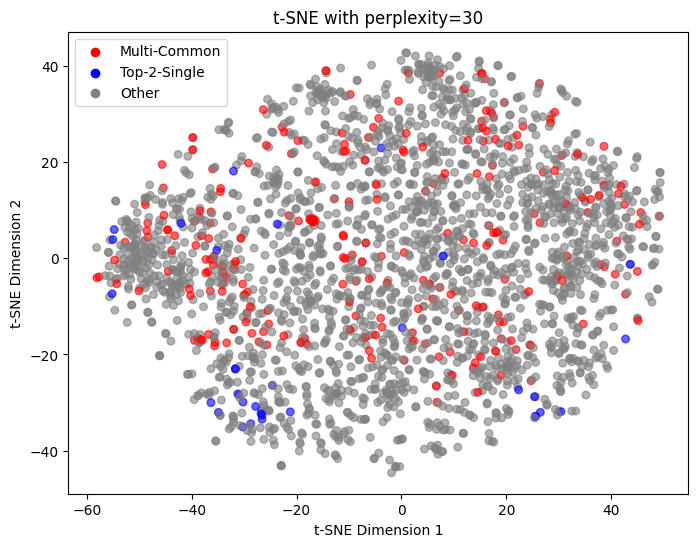

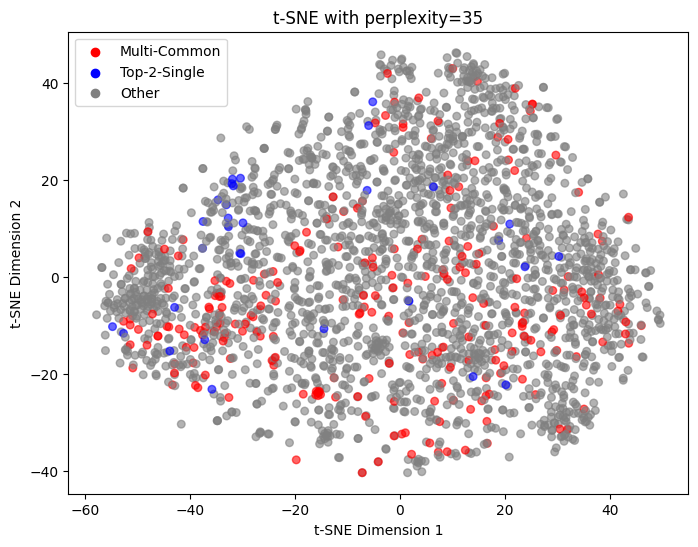

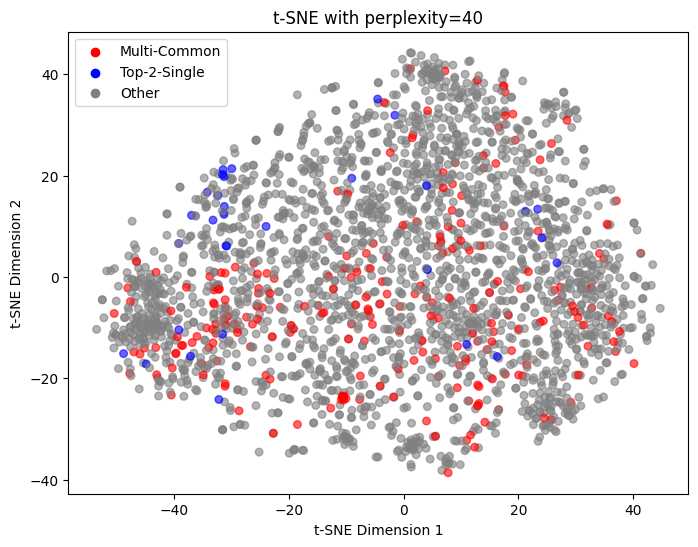

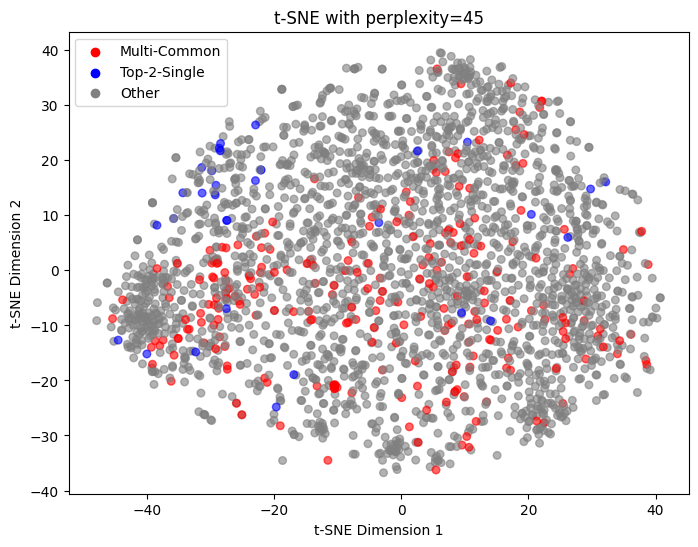

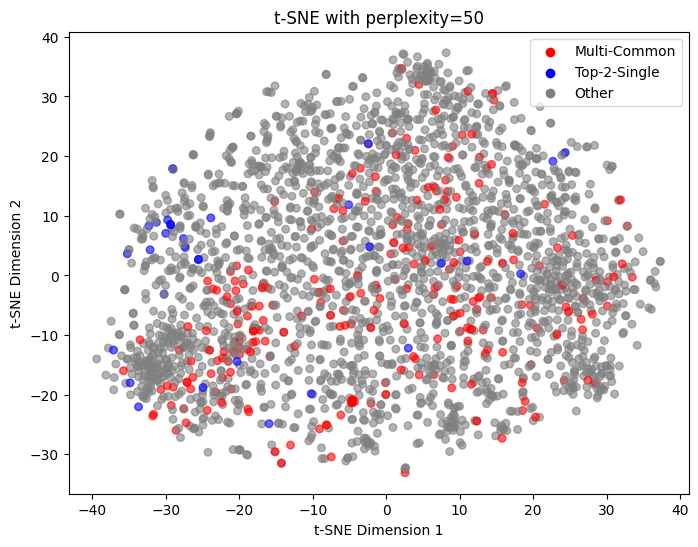

In [ ]:
from sklearn.manifold import TSNE
perplexities = [5,10,15,20,25,30,35,40,45,50]
tsne_results = {}

for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp)
    X_embedded = tsne.fit_transform(X_scaled)
    tsne_results[perp] = X_embedded

def plot_tsne(X_embedded, labels, title):

    color_map = {
        "Multi-Common": "red",
        "Top-2-Single": "blue",
        "Other": "grey"
    }
    colors = labels.map(color_map)
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, alpha=0.6, s=30)
    

    for category, color in color_map.items():
        plt.scatter([], [], c=color, label=category)
    plt.legend()
    
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

for perp in perplexities:
    plot_tsne(tsne_results[perp], labels_for_vis, title=f"t-SNE with perplexity={perp}")

#### I choose a perplexity of 30

Reason :

- Perplexity 5 heavily emphasizes local structure, resulting in a fragmented and less coherent map, which can create many small clusters

- Perplexity 50 over-emphasizes the global structure, making the resulting map look too compact and merges distinct local features.

- Perplexity 30 strikes a good balance, revealing the overall shape of the data while preserving a reasonable amount of local neighborhood information.

## 2. Visualisation

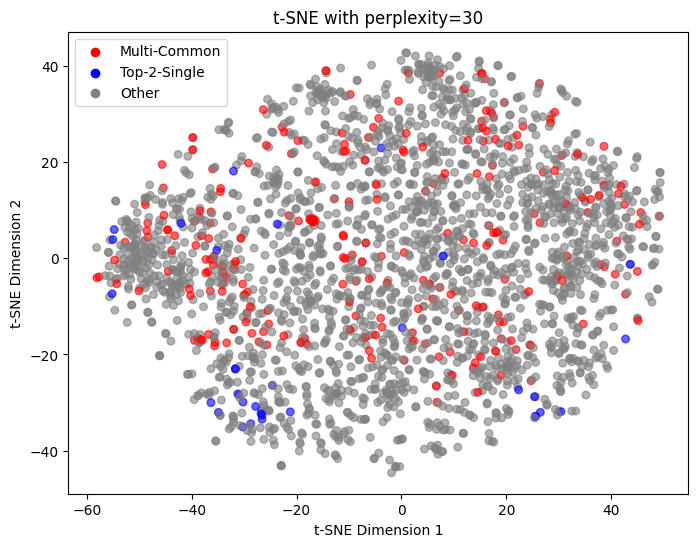

In [38]:
plot_tsne(tsne_results[30], labels_for_vis, title=f"t-SNE with perplexity={30}")

## 3. Veracity Inspection


### Noisy/Ambiguous Labels

* The central, dense body from roughly $x \approx -15$ to $20$ and $y \approx -10$ to $10$ is gray-dominant with many embedded red points and a few blue points, consistent with labels that conflict with their local neighbors in the embedding.

* The upper-right gray region around $x \approx 30, y \approx 15$ contains scattered embedded red points, again suggesting items whose local neighbors disagree with their assigned class, a known sign of label noise or ambiguous membership.

* The left-center area around $x \approx -30, y \approx 0$ shows gray-heavy neighborhoods peppered with red points; such "one color inside another" patterns indicate local disagreement rather than clean cluster boundaries.

### Outliers

* Individual points on the far periphery (e.g., near $x \approx 50, y \approx -15$; $x \approx 48, y \approx 10$; and $x \approx 40, y \approx -35$) sit well outside the main mass and appear as isolated singletons, consistent with outliers.

* A tiny, distant blue micro-cluster in the lower-left around $x \approx -35, y \approx -35$, along with a few extreme-left points near $x \approx -60, y \approx -5$, forms small satellites. 

* Given t-SNE’s emphasis on local neighborhoods, these outliers should be validated with alternative methods before drawing biological or functional conclusions.

* Possible Hypotheses : These could correspond to rare or extreme expression patterns, sequencing artifacts, or biological subtypes underrepresented in the dataset.

### Hard-to-Learn Samples

* Broad mixed-color bands across the plot—especially the central belt ($x \approx -10$ to $15$, $y \approx -5$ to $10$) and the upper-middle zone ($x \approx 5$ to $20$, $y \approx 20$ to $30$)—show thorough interleaving of red, blue, and gray points. This implies **overlapping local neighborhoods that a simple classifier would struggle to linearly separate**.

* Because t-SNE preserves local structure based on a perplexity setting (here 30), such mixing suggests that classes share neighbors in the original high-dimensional space. This increases classification difficulty and **demands non-linear or higher-capacity models** to create effective decision boundaries.


# Part C : Isomap and Manifold Learning

## Isomap Implementation

In [40]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=5)  
X_isomap = isomap.fit_transform(X_scaled)


### **Isomap**

**Idea:**
Isomap seeks to preserve the **global geometry of the data manifold** by approximating geodesic distances between all pairs of points.

**Steps:**
1.  Construct a k-nearest neighbor (k-NN) graph.
2.  Compute geodesic distances between all pairs of points using shortest paths:
    $$
    d_G(i,j) = \min_{\text{paths } i \to j} \sum_{(u,v)\in \text{path}} \|x_u - x_v\|
    $$
3.  Apply Multidimensional Scaling (MDS) on the geodesic distance matrix $D_G$ by minimizing:
    $$
    \min_{Y} \sum_{i,j} \left( d_G(i,j) - \|y_i - y_j\| \right)^2
    $$

**Effect:**
* Preserves global manifold structure.
* Distances between far-apart points are meaningful.


### **t-SNE**

**Idea:**
t-SNE focuses on preserving **local neighborhood similarities** rather than global geometry.

**Steps:**
1.  Define high-dimensional pairwise similarity:
    $$
    p_{j|i} = \frac{\exp\!\left(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\!\left(-\frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}
    $$
    with perplexity controlling the scale of $\sigma_i$.
    Symmetrize:
    $$
    p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
    $$
2.  In low dimensions, define similarity using a Student-t distribution:
    $$
    q_{ij} = \frac{\left(1 + \|y_i - y_j\|^2 \right)^{-1}}{\sum_{k \neq l} \left(1 + \|y_k - y_l\|^2 \right)^{-1}}
    $$
3.  Minimize Kullback–Leibler (KL) divergence between distributions:
    $$
    \min_{Y} \; KL(P \| Q) = \sum_{i,j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
    $$

**Effect:**
* Preserves local neighborhoods.
* Reveals clusters, but **distorts global distances.
* Separation between clusters in 2D may not reflect true separation in high dimensions.

## 2. Visualisation

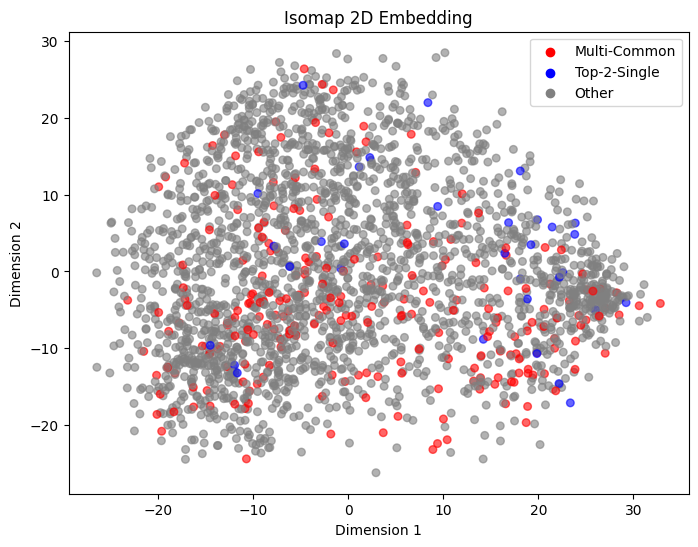

In [41]:
def plot_embedding(X_embedded, labels, title):
    color_map = {
        "Multi-Common": "red",
        "Top-2-Single": "blue",
        "Other": "grey"
    }
    colors = labels.map(color_map)
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, alpha=0.6, s=30)
    for category, color in color_map.items():
        plt.scatter([], [], c=color, label=category)
    plt.legend()
    
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

plot_embedding(X_isomap, labels_for_vis, title="Isomap 2D Embedding")

## 3. Comparison and curvature

### Isomap's Global View

The Isomap plot displays the data as a single, wide, continuous parabolic shape. This visualization suggests the data's overall structure is one connected group, not a set of separate clusters. The way the points are spread across this large shape preserves the large-scale distances between them, giving a faithful picture of the entire data landscape.

### t-SNE's Local View

The t-SNE plot arranges the data into a more condensed, circular cloud. While this view is better at showing tight-knit local neighborhoods (like the small group of blue dots in the lower-left), the overall circular shape is an artifact of the algorithm. It prioritizes these local relationships by pulling all the points together, which distorts the true global structure seen in the Isomap plot.

- Hence, Isomap is better at revealing the global structure.

### The Data Manifold Concept

The data manifold refers to the lower-dimensional, non-linear subspace on which the high-dimensional data is assumed to lie. This is based on the manifold hypothesis, which posits that real-world high-dimensional datasets (like gene expression profiles) are concentrated near a manifold of much lower intrinsic dimensionality. Manifold learning algorithms like Isomap aim to discover this underlying structure by preserving properties such as geodesic distances.

### Manifold Complexity and the Isomap Plot

The Isomap visualization provides an isometric embedding of the presumed data manifold into a 2D space. Based on the plot, the manifold exhibits the following characteristics:

- Low Curvature: The data is arranged along a gentle, continuous parabolic curve. This indicates that the manifold is not highly complex, convoluted, or self-intersecting. A highly curved manifold would require more complex non-linear transformations to embed without significant distortion.

- Simple Topology: The plot shows a single, connected component, suggesting a simple topological structure without holes or disconnected segments.

Therefore, the Isomap plot suggests the data lies on a manifold with low intrinsic dimensionality and relatively simple geometry.

### Manifold Complexity vs. Classification Difficulty

The difficulty of a classification task is determined by two primary factors:

- The geometric complexity of the manifold.

- The separability of the classes on that manifold.

While the manifold itself appears geometrically simple, the provided visualizations demonstrate poor class separability. The 'Multi-Common' (red), 'Top-2-Single' (blue), and 'Other' (gray) classes are highly interspersed across the entire length of the parabolic manifold.

The implication for classification is critical: the challenge is not due to a complex manifold, but to low class separability on a simple manifold. A linear classifier, or any classifier that relies on finding a simple decision boundary, would perform poorly because no such boundary can be drawn in the feature space to effectively partition the classes. The high degree of overlap means that local neighborhoods on the manifold contain points from multiple classes, making the classification task inherently difficult and likely requiring a non-linear model with high capacity to learn the intricate, mixed distributions.